In [ ]:
!pip install stellargraph

In [2]:
from collections import defaultdict, Counter
import numpy as np
import pandas as pd
import csv
import os
from google.colab import drive
from tqdm.notebook import tqdm
import stellargraph as sg
import matplotlib.pyplot as plt
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import preprocessing, model_selection
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
import re
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
DATA_SOURCE = "wiki"
# DATA_SOURCE = "apr"

In [ ]:
drive.mount('/content/drive')

In [4]:
CLASS_MAPPINGS = {
    # Person
    "person": "Person",
    "per": "Person",
    "PERSON": "Person",

    # Organization
    "ORGANIZATION": "Organization",
    "org": "Organization",

    # Location
    "LOCATION": "Location",
    "loc": "Location",
    "trans": "Location",

    # Event
    "event": "Event",
    "EVENT": "Event",

    # Product
    "product": "Product",
    "PRODUCT": "Product",
    "tech": "Product",

    # Time
    "time": "Time",
    "YEAR": "Time",
    "DAY": "Time",
    "MONTH": "Time",
    "WEEKDAY": "Time",

    # Biochem
    "biochem": "Biochem",

    # Number
    "DIGITRANK": "Number",
    "DIGIT": "Number",

    # Art
    "art": "Art",
    "MOVIE": "Art",

    # Religion
    "RELIGION": "Religion",

    # Unit
    "LENGTHUNIT": "Unit",
    "DIGITUNIT": "Unit",
    "TIMEUNIT": "Unit",
}

--------------------------------------------------------------------------------
# Reading and merging apr and wiki datasets

In [5]:
def read_data(path):
  entity2id_path = os.path.join(path, 'entity2id.txt')
  eidSkipgram2TFIDFStrength_path = os.path.join(path, 'eidSkipgram2TFIDFStrength.txt')
  eidCTypeStrengths_path = os.path.join(path, 'eidCTypeStrengths.txt')

  # entity2id.txt

  id_to_entities = defaultdict(set)
  entities_to_id = dict()
  print("Reading entity2id.txt...")
  with open(entity2id_path, newline='') as f:
    reader = csv.DictReader(f, fieldnames=['entity', 'id'], delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
      id_to_entities[int(row['id'])].add(row['entity']) # id odpowiada jednemu lub wielu entity
      entities_to_id[row['entity']] = int(row['id']) # jedno entity odpowiada zawsze tylko jednemu id

  # eidSkipgram2TFIDFStrength.txt

  id_to_slots = defaultdict(set)
  slots_to_ids = defaultdict(set)
  print("Reading eidSkipgram2TFIDFStrength.txt...")
  with open(eidSkipgram2TFIDFStrength_path) as f:
    reader = csv.DictReader(f, fieldnames=['id', 'entity', 'x', 'y'], delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
      id_to_slots[int(row['id'])].add(row['entity'].strip())
      # slots_to_ids[row['entity'].strip()].add(int(row['id']))

  # eidSkipgram2TFIDFStrength.txt

  id_to_class = defaultdict(list)
  id_to_strengths = defaultdict(list)

  print("Reading eidCTypeStrengths.txt...")
  with open(eidCTypeStrengths_path) as f:
    reader = csv.DictReader(f, fieldnames=['id', 'class', 'x', 'y'], delimiter='\t', quoting=csv.QUOTE_NONE)
    for row in tqdm(reader):
      id_to_class[int(row['id'])].append(CLASS_MAPPINGS[row['class']])
      id_to_strengths[int(row['id'])].append([float(row['x']), float(row['y'])])
      assert len(id_to_class[int(row['id'])]) == len(id_to_strengths[int(row['id'])])

  return id_to_entities, entities_to_id, id_to_slots, id_to_class, id_to_strengths

In [ ]:
# Reading data
print(f"Reading {DATA_SOURCE} dataset...")
data_id_to_entity, data_entities_to_id, data_id_to_slots, data_id_to_class, data_id_to_strengths = read_data(os.path.join('drive', 'My Drive', 'Studia', 'DW', DATA_SOURCE, 'intermediate'))

In [ ]:
# Merging data
next_id = max(data_id_to_entity.keys()) + 1

id_to_entities = data_id_to_entity
id_to_classes = data_id_to_class
id_to_slots = data_id_to_slots
id_to_strengths = data_id_to_strengths

print('Lets start...')

for id_, id_classes in tqdm(list(id_to_classes.items())):
  if len(id_classes) > 1:
    for i, class_name in enumerate(id_classes[1:]):
      id_to_entities[next_id].update(data_id_to_entity[id_])
      id_to_slots[next_id].update(data_id_to_slots[id_])
      id_to_classes[next_id] = class_name
      id_to_strengths[next_id] = data_id_to_strengths[id_][i+1]
      next_id += 1
  id_to_classes[id_] = id_classes[0]
  id_to_strengths[id_] = data_id_to_strengths[id_][0]

last_id = next_id - 1 

In [ ]:
for i in range(last_id + 1):
  assert i in id_to_entities

In [ ]:
for x in id_to_strengths.values():
  assert len(x) == 2

In [ ]:
assert len(id_to_entities) == len(id_to_classes) == len(id_to_slots) == len(id_to_strengths)
print(f"Gathered {len(id_to_entities)} ids :)")

In [ ]:
path = os.path.join('drive', 'My Drive', 'Studia', 'DW')
id2entity_path = os.path.join(path, 'id2entity.txt')
id2class_path = os.path.join(path, 'id2class&strengths.txt')
id2slots_path = os.path.join(path, 'id2slots.txt')

In [ ]:
# Saving merged data into files

print("Writing id2entity.txt")
with open(id2entity_path, 'w') as f:
    fieldnames = ['id', 'entity']
    writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE, escapechar='\\')
    for entity_id, entities in id_to_entities.items():
      for entity in entities:
          writer.writerow({'id': entity_id, 'entity': entity})

print("Writing id2class&strengths.txt")
with open(id2class_path, 'w') as f:
    fieldnames = ['id', 'class', 'strength1', 'strength2']
    writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE, escapechar='\\')
    for entity_id, class_name in id_to_classes.items():
        writer.writerow({
            'id': entity_id,
            'class': class_name,
            'strength1': id_to_strengths[entity_id][0], 
            'strength2': id_to_strengths[entity_id][1]
            })

print("Writing id2slots.txt")
with open(id2slots_path, 'w') as f:
    fieldnames = ['id', 'slot']
    writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE, escapechar='\\')
    for entity_id, slots in id_to_slots.items():
      for slot in slots:
          writer.writerow({'id': entity_id, 'slot': slot})



-------------------------------------------------------------------------------
# Reading and cutting merged data

In [ ]:
path = os.path.join('drive', 'My Drive', 'Studia', 'DW')
id2entity_path = os.path.join(path, 'id2entity.txt')
id2class_path = os.path.join(path, 'id2class&strengths.txt')
id2slots_path = os.path.join(path, 'id2slots.txt')

In [ ]:
print("Reading id2slots.txt...")
slots_to_ids = defaultdict(set)
with open(id2slots_path) as f:
    fieldnames = ['id', 'slot']
    reader = csv.DictReader(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE, escapechar='\\')
    i = 0 
    for row in tqdm(reader):
      slots_to_ids[row['slot'].strip()].add(int(row['id']))

In [ ]:
def check_how_many_edges(slots_to_ids, n):
  temp = [len(ids) for ids in slots_to_ids.values() if len(ids) > 1 and len(ids) <= n]
  n_edges = 0
  for n_ids in temp:
    n_edges += int(n_ids / 2 * (n_ids - 1))
  print(f"There would be max {n_edges} edges")

In [ ]:
check_how_many_edges(slots_to_ids, 15)

In [ ]:
slots_to_ids = {slot: ids for slot, ids in slots_to_ids.items() if len(ids) > 1 and len(ids) <= 15}

In [ ]:
sources = []
targets = []
sources_and_targets = set()
for slot in tqdm(list(slots_to_ids.keys())):
  ids = slots_to_ids[slot]
  n_ids = len(ids)
  list_ids = list(ids)
  for i in range(n_ids-1):
    for j in range(i+1, n_ids):
      sources_and_targets.add((list_ids[i], list_ids[j]))
  del slots_to_ids[slot]

for s, t in tqdm(sources_and_targets):
  sources.append(s)
  targets.append(t)

print(f"{len(sources_and_targets)} edges")
assert len(sources) == len(targets)
nodes = set(sources + targets)


In [ ]:
# Reading classes
ids_to_class = dict()
# class_to_entities = defaultdict(set)
ids_to_strengths = dict()
print("Reading id2class.txt...")
with open(id2class_path) as f:
  fieldnames = ['id', 'class', 'strength1', 'strength2']
  reader = csv.DictReader(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE)
  for row in tqdm(reader, total=780032):
    if int(row['id']) in nodes:
      assert int(row['id']) not in ids_to_class and int(row['id']) not in ids_to_strengths
      ids_to_class[int(row['id'])] = row['class']
      # class_to_entities[row['class']].update(ids_to_entities[int(row['id'])])
      ids_to_strengths[int(row['id'])] = [row['strength1'], row['strength2']]

assert len(ids_to_class) == len(nodes) == len(ids_to_strengths)

In [ ]:
# N most common words in class - this approach was rejected

# omitted_words = {'the', 'an'}
# n_common = dict()
# regex = r'\b[^\d\W]{2,}\b'
# n = 30
# for c, entities in class_to_entities.items():
#   class_counter = Counter()

#   for entity in entities:
#     words=set(re.findall(regex,entity))
#     words -= omitted_words
#     class_counter.update(words)
#   n_common[c] = class_counter.most_common(n)

In [ ]:
# common_words = list({word[0] for words in n_common.values() for word in words})

In [ ]:
# def create_feature_vector(entities, common_entities):
#   f_vector = [0]*len(common_entities)

#   for i, common_enity in enumerate(common_entities):
#     if any([re.search(fr'\b{common_enity}\b', entity) for entity in entities]):
#       f_vector[i] = 1
#   return np.array(f_vector)


In [ ]:
edges = pd.DataFrame(
    {"source": sources, "target": targets}
)

features = defaultdict(list)
# features = list()
data_nodes = []
for entity_id in tqdm(nodes):
  # feature_vector = create_feature_vector(ids_to_entities[entity_id], common_words)
  # features.append(feature_vector)
  data_nodes.append(entity_id)
  features['s1'].append(ids_to_strengths[entity_id][0])
  features['s2'].append(ids_to_strengths[entity_id][1])

In [ ]:
print(f"Converting {DATA_SOURCE} data into dataframe...")
data = pd.DataFrame(features, index=data_nodes)

In [ ]:
Gs = sg.StellarGraph(data, edges=edges)
Gs.info()

In [ ]:
ids_to_class = pd.Series(ids_to_class)

In [ ]:
# split the data 
def split_data(class_series, train_split, test_split):
  assert train_split + test_split <= 1
  n_trains = int(train_split * class_series.shape[0])
  n_tests = int(test_split * class_series.shape[0])

  train_data, test_data = model_selection.train_test_split(class_series, train_size=n_trains, test_size=None, stratify=class_series)
  test_data, val_data = model_selection.train_test_split(test_data, train_size=n_tests, test_size=None, stratify=test_data)

  return train_data, test_data, val_data

In [ ]:
train_data, test_data, val_data = split_data(ids_to_class, 0.8, 0.1)

In [ ]:
target_encoding = preprocessing.LabelBinarizer()
y_train = target_encoding.fit_transform(train_data)
y_test = target_encoding.transform(test_data)
y_val = target_encoding.transform(val_data)

In [ ]:
del sources
del edges
del targets
del data
del features
del data_nodes

In [ ]:
y_integers = np.argmax(y_train, axis=1)
weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(weights))


In [ ]:
Counter(y_integers)

In [ ]:
from keras import backend as K
def weighted_categorical_crossentropy(weights):  
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

-----------------------------------------------------------------------------
# Training

In [ ]:
generator = sg.mapper.FullBatchNodeGenerator(Gs, method="gcn")
train_gen = generator.flow(train_data.index, y_train)
dropouts = [0.1, 0.2, 0.3]
layers_sizes = [[128, 64, 32], [128, 64, 16], [128, 32, 16], [64, 32, 16], [64, 32], [64, 16], [32, 16], [16,16], [32,32], [64,64], [128,128], [128, 64, 32, 16], [64, 32, 24, 16],]
i = 0
with open(os.path.join('drive', 'My Drive', 'Studia', 'DW', 'results_with_strengths.tsv'), 'w') as f:
  fieldnames = ["layers_sizes", 'dropout', "test_f1_score", "test_precision", "test_recall", "test_accuracy", "model_name"]
  writer = csv.DictWriter(f, fieldnames=fieldnames, delimiter = '\t')
  for dropout in dropouts:
    for layer_sizes in layers_sizes:
      gcn = sg.layer.GCN(layer_sizes=layer_sizes, activations=["relu"]*len(layer_sizes), generator=generator, dropout=dropout)

      x_inp, x_out = gcn.in_out_tensors()

      predictions = layers.Dense(units=y_train.shape[1], activation="softmax")(x_out)

      model = Model(inputs=x_inp, outputs=predictions)
      val_gen = generator.flow(val_data.index, y_val)
      es_callback = EarlyStopping(monitor="val_acc", patience=200, restore_best_weights=True)
      reducer = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=60)
      mcp_save = ModelCheckpoint(os.path.join('drive', 'My Drive', 'Studia', 'DW', f'model_{i}.h5'), save_best_only=True, monitor='val_loss', mode='min')

      model.compile(optimizer=optimizers.Adam(lr=0.01), loss=weighted_categorical_crossentropy(weights), metrics=['acc',f1_m, precision_m, recall_m])
      history = model.fit(
          train_gen,
          epochs=5000,
          validation_data=val_gen,
          verbose=2,
          # class_weight=d_class_weights, # bug - https://github.com/stellargraph/stellargraph/issues/603 
          shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
          callbacks=[es_callback, reducer, mcp_save],
      )
      test_loss, test_acc, test_f1, test_precision, test_recall = model.evaluate(generator.flow(test_data.index, y_test))
      result_dict = {
          "layers_sizes": layer_sizes,
          "dropout": dropout,
          "test_f1_score": test_f1,
          "test_precision": test_precision,
          "test_recall": test_recall ,
          "test_accuracy": test_acc,
          "model_name": f"model_{i}.h5"
      }

      print(f"{i}: \n{result_dict}\n")
      writer.writerow(result_dict)
      K.clear_session()
      i += 1

Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 1.4873 - acc: 0.4703 - f1_m: 0.3549 - precision_m: 0.6647 - recall_m: 0.2421 - val_loss: 1.4097 - val_acc: 0.5016 - val_f1_m: 0.4160 - val_precision_m: 0.7082 - val_recall_m: 0.2945 - lr: 1.0000e-05
Epoch 666/5000
1/1 - 0s - loss: 1.4800 - acc: 0.4705 - f1_m: 0.3544 - precision_m: 0.6676 - recall_m: 0.2413 - val_loss: 1.4097 - val_acc: 0.5016 - val_f1_m: 0.4160 - val_precision_m: 0.7083 - val_recall_m: 0.2945 - lr: 1.0000e-05
1/1 [==============================] - 0s 1ms/step - loss: 1.4218 - acc: 0.5117 - f1_m: 0.4134 - precision_m: 0.7260 - recall_m: 0.2890
35: 
{'layers_sizes': [64, 64], 'dropout': 0.3, 'test_f1_score': 0.41337764263153076, 'test_precision': 0.7259793281555176, 'test_recall': 0.2889554798603058, 'test_accuracy': 0.511721134185791, 'model_name': 'model_35.h5'}

Epoch 1/5000
1/1 - 0s - loss: 2.1212 - acc: 0.1279 - f1_m: 4.1363e-05 - precision_m: 0.1452 - recall_m: 2.0684e-05 - val_loss: 1.9828 - val_a

Console:

javascript:void(setInterval(function(){ console.log("Connect pushed"); document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click(); },60000)) 

In [ ]:
# visualizing results
acc_matrix = np.zeros((3, 13))
f1_matrix = np.zeros((3, 13))
precision_matrix = np.zeros((3, 13))
recall_matrix = np.zeros((3, 13))

dropouts = [0.1, 0.2, 0.3]
layers_sizes = [[128, 64, 32], [128, 64, 16], [128, 32, 16], [64, 32, 16], [64, 32], [64, 16], [32, 16], [16,16], [32,32], [64,64], [128,128], [128, 64, 32, 16], [64, 32, 24, 16],]


with open(os.path.join(path, "results_with_strengths.tsv")) as f:
  i = 0
  j = 0
  reader = csv.DictReader(f, delimiter='\t', fieldnames=["layers_sizes", 'dropout', "test_f1_score", "test_precision", "test_recall", "test_accuracy", "model_name"])
  for row in reader:
    if j % 13 == 0 and j != 0:
      i += 1
      j = 0
    acc_matrix[i,j] = row["test_accuracy"]
    f1_matrix[i,j] = row["test_f1_score"]
    precision_matrix[i,j] = row["test_accuracy"]
    recall_matrix[i,j] = row["test_recall"]
    j += 1



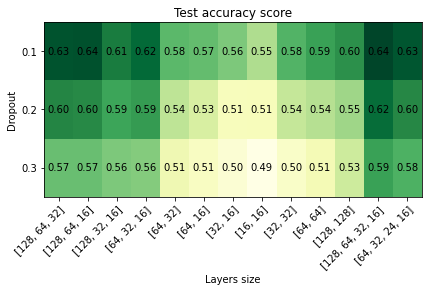

In [ ]:
fig, ax = plt.subplots()
im = plt.imshow(acc_matrix, cmap='YlGn', aspect=2)
ax.set_xticks(np.arange(len(layers_sizes)))
ax.set_yticks(np.arange(len(dropouts)))
ax.set_xticklabels(layers_sizes)
ax.set_yticklabels(dropouts)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(dropouts)):
    for j in range(len(layers_sizes)):
        text = ax.text(j, i, "%.2f" % acc_matrix[i, j],
                       ha="center", va="center", color="black")
fig.tight_layout()
ax.set_title("Test accuracy score")
plt.xlabel('Layers size')
plt.ylabel('Dropout')
plt.show()

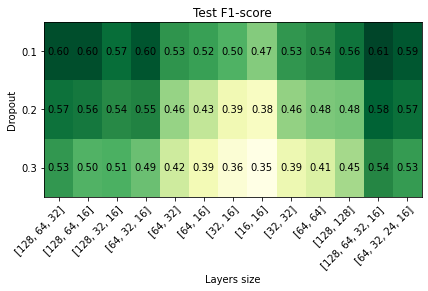

In [ ]:
fig, ax = plt.subplots()
im = plt.imshow(f1_matrix, cmap='YlGn', aspect=2)
ax.set_xticks(np.arange(len(layers_sizes)))
ax.set_yticks(np.arange(len(dropouts)))
ax.set_xticklabels(layers_sizes)
ax.set_yticklabels(dropouts)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(dropouts)):
    for j in range(len(layers_sizes)):
        text = ax.text(j, i, "%.2f" % f1_matrix[i, j],
                       ha="center", va="center", color="black")
fig.tight_layout()
ax.set_title("Test F1-score")
plt.xlabel('Layers size')
plt.ylabel('Dropout')
plt.show()

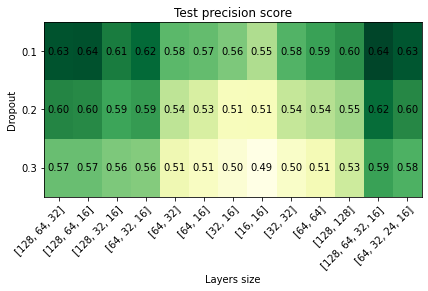

In [ ]:
fig, ax = plt.subplots()
im = plt.imshow(precision_matrix, cmap='YlGn', aspect=2)
ax.set_xticks(np.arange(len(layers_sizes)))
ax.set_yticks(np.arange(len(dropouts)))
ax.set_xticklabels(layers_sizes)
ax.set_yticklabels(dropouts)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(dropouts)):
    for j in range(len(layers_sizes)):
        text = ax.text(j, i, "%.2f" % precision_matrix[i, j],
                       ha="center", va="center", color="black")
fig.tight_layout()
ax.set_title("Test precision score")
plt.xlabel('Layers size')
plt.ylabel('Dropout')
plt.show()

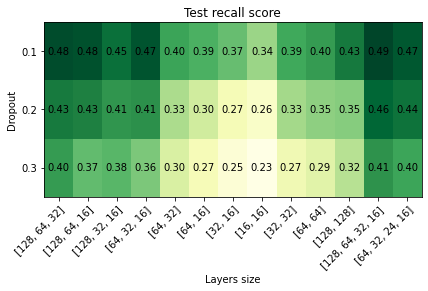

In [ ]:
fig, ax = plt.subplots()
im = plt.imshow(recall_matrix, cmap='YlGn', aspect=2)
ax.set_xticks(np.arange(len(layers_sizes)))
ax.set_yticks(np.arange(len(dropouts)))
ax.set_xticklabels(layers_sizes)
ax.set_yticklabels(dropouts)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(dropouts)):
    for j in range(len(layers_sizes)):
        text = ax.text(j, i, "%.2f" % recall_matrix[i, j],
                       ha="center", va="center", color="black")
fig.tight_layout()
ax.set_title("Test recall score")
plt.xlabel('Layers size')
plt.ylabel('Dropout')
plt.show()

In [ ]:
model = load_model(os.path.join(path, "model_11.h5"), custom_objects={
    "loss": weighted_categorical_crossentropy,
    "f1_m": f1_m,
    "precision_m": precision_m,
    "recall_m": recall_m,
    "SqueezedSparseConversion": sg.layer.SqueezedSparseConversion,
    "GraphConvolution": sg.layer.GraphConvolution,
    "GatherIndices": sg.layer.GatherIndices
})

In [ ]:
# Reading entities
ids_to_entities = dict()

with open(id2entity_path) as f:
  fieldnames = ['id', 'entity']
  reader = csv.DictReader(f, fieldnames=fieldnames, delimiter = '\t', quoting=csv.QUOTE_NONE)
  for row in tqdm(reader):
    if int(row['id']) in nodes:
      ids_to_entities[int(row['id'])] = row['entity'].strip().lower()


In [ ]:
generator = sg.mapper.FullBatchNodeGenerator(Gs, method="gcn")

all_nodes = test_data.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
df = pd.DataFrame({"Predicted": node_predictions, "True": test_data})
df.head(50)

Using GCN (local pooling) filters...


,Predicted,True
366859,Location,Location
127843,Person,Person
761573,Product,Product
24252,Person,Person
397100,Person,Person
463020,Art,Art
402415,Location,Person
398069,Person,Person
539496,Person,Person
490249,Location,Location


In [ ]:
df.rename(index=ids_to_entities)[685:700]


,Predicted,True
william i,Person,Person
dobrich province,Location,Location
disney 's boardwalk villas,Organization,Location
nora barnacle,Person,Person
dave peyton,Person,Person
louisville and nashville railroad,Organization,Organization
union of right forces,Event,Organization
rupununi river,Location,Location
watling street,Time,Location
george ferguson,Person,Person


In [ ]:
(df[df['Predicted'] == 'Time'])

,Predicted,True
44722,Time,Art
776344,Time,Person
78889,Time,Product
494758,Time,Art
272708,Time,Person
...,...,...
611212,Time,Product
361410,Time,Location
545606,Time,Biochem
295874,Time,Time
